In [1]:
################################################################################################################################
#
# LSTM - JANSEN - MINMAX - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1024.70 | Test RMSE: 1225.61'
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-MinMax-Daily')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV'
#ESCALA = 'minmax' 
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32
window_size = 21 # 63

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-03,16930.42
2000-01-04,15851.00
2000-01-05,16245.14
2000-01-06,16106.89
2000-01-07,16309.15
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


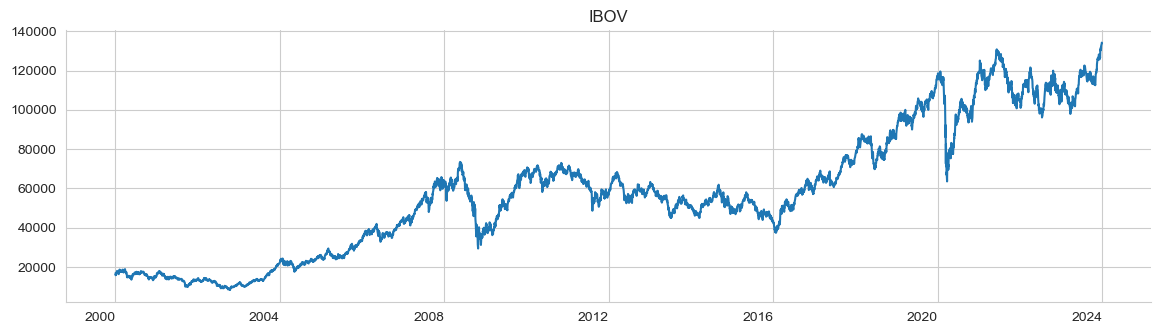

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: SCALE - MINMAX - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2022']).squeeze(), index=df[:'2022'].index)
df_scaled

Date
2000-01-03    0.069928
2000-01-04    0.061109
2000-01-05    0.064329
2000-01-06    0.063200
2000-01-07    0.064852
                ...   
2022-12-23    0.827796
2022-12-26    0.819955
2022-12-27    0.818651
2022-12-28    0.832201
2022-12-29    0.828099
Length: 5695, dtype: float64

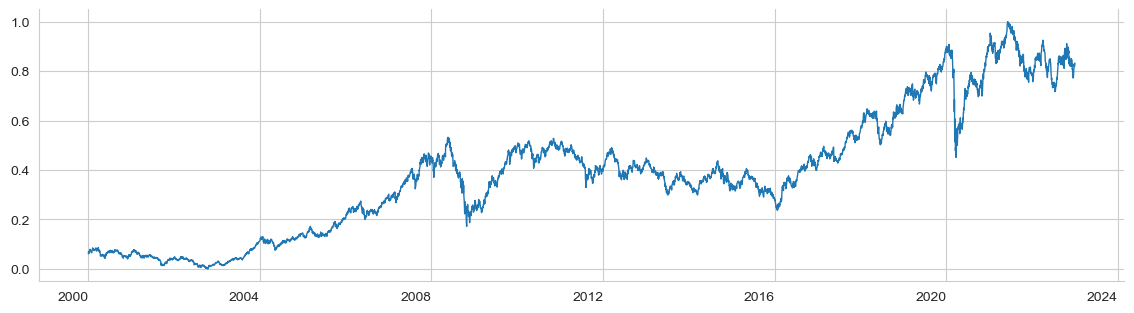

In [8]:
#===============================================================================================================================
# DATA: MINMAX - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: MINMAX - SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-12-01':]).squeeze(), index=df['2022-12-01':].index)
df_scaledtest

Date
2022-12-01    0.837828
2022-12-02    0.845984
2022-12-05    0.825376
2022-12-06    0.831807
2022-12-07    0.822657
                ...   
2023-12-21    1.011484
2023-12-22    1.016148
2023-12-26    1.022521
2023-12-27    1.027919
2023-12-28    1.027850
Length: 269, dtype: float64

In [10]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [11]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-02,0.069928,0.061109,0.064329,0.063200,0.064852,0.070677,0.067006,0.067366,0.072931,0.075871,...,0.077875,0.074338,0.071940,0.070776,0.070265,0.071356,0.071159,0.068326,0.065499,0.066593
2000-02-03,0.061109,0.064329,0.063200,0.064852,0.070677,0.067006,0.067366,0.072931,0.075871,0.079101,...,0.074338,0.071940,0.070776,0.070265,0.071356,0.071159,0.068326,0.065499,0.066593,0.069422
2000-02-04,0.064329,0.063200,0.064852,0.070677,0.067006,0.067366,0.072931,0.075871,0.079101,0.077875,...,0.071940,0.070776,0.070265,0.071356,0.071159,0.068326,0.065499,0.066593,0.069422,0.074231
2000-02-07,0.063200,0.064852,0.070677,0.067006,0.067366,0.072931,0.075871,0.079101,0.077875,0.074338,...,0.070776,0.070265,0.071356,0.071159,0.068326,0.065499,0.066593,0.069422,0.074231,0.078114
2000-02-08,0.064852,0.070677,0.067006,0.067366,0.072931,0.075871,0.079101,0.077875,0.074338,0.071940,...,0.070265,0.071356,0.071159,0.068326,0.065499,0.066593,0.069422,0.074231,0.078114,0.079692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.845227,0.821907,0.820317,0.837698,0.850576,0.837828,0.845984,0.825376,0.831807,0.822657,...,0.810003,0.792224,0.777489,0.779172,0.779106,0.771901,0.787293,0.804648,0.809297,0.810264
2022-12-26,0.821907,0.820317,0.837698,0.850576,0.837828,0.845984,0.825376,0.831807,0.822657,0.807793,...,0.792224,0.777489,0.779172,0.779106,0.771901,0.787293,0.804648,0.809297,0.810264,0.827796
2022-12-27,0.820317,0.837698,0.850576,0.837828,0.845984,0.825376,0.831807,0.822657,0.807793,0.810003,...,0.777489,0.779172,0.779106,0.771901,0.787293,0.804648,0.809297,0.810264,0.827796,0.819955


In [12]:
#===============================================================================================================================
# DATA PREP: TRAIN
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

In [13]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.837828,0.845984,0.825376,0.831807,0.822657,0.807793,0.810003,0.792224,0.777489,0.779172,...,0.771901,0.787293,0.804648,0.809297,0.810264,0.827796,0.819955,0.818651,0.832201,0.828099
2023-01-03,0.845984,0.825376,0.831807,0.822657,0.807793,0.810003,0.792224,0.777489,0.779172,0.779106,...,0.787293,0.804648,0.809297,0.810264,0.827796,0.819955,0.818651,0.832201,0.828099,0.800660
2023-01-04,0.825376,0.831807,0.822657,0.807793,0.810003,0.792224,0.777489,0.779172,0.779106,0.771901,...,0.804648,0.809297,0.810264,0.827796,0.819955,0.818651,0.832201,0.828099,0.800660,0.782603
2023-01-05,0.831807,0.822657,0.807793,0.810003,0.792224,0.777489,0.779172,0.779106,0.771901,0.787293,...,0.809297,0.810264,0.827796,0.819955,0.818651,0.832201,0.828099,0.800660,0.782603,0.792151
2023-01-06,0.822657,0.807793,0.810003,0.792224,0.777489,0.779172,0.779106,0.771901,0.787293,0.804648,...,0.810264,0.827796,0.819955,0.818651,0.832201,0.828099,0.800660,0.782603,0.792151,0.810997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.961268,0.965684,0.957036,0.958786,0.965378,0.962333,0.971855,0.978830,0.967538,0.968359,...,0.961058,0.969914,0.968467,0.964272,0.989288,1.000538,0.995268,1.002513,1.008779,1.000228
2023-12-22,0.965684,0.957036,0.958786,0.965378,0.962333,0.971855,0.978830,0.967538,0.968359,0.957897,...,0.969914,0.968467,0.964272,0.989288,1.000538,0.995268,1.002513,1.008779,1.000228,1.011484
2023-12-26,0.957036,0.958786,0.965378,0.962333,0.971855,0.978830,0.967538,0.968359,0.957897,0.961058,...,0.968467,0.964272,0.989288,1.000538,0.995268,1.002513,1.008779,1.000228,1.011484,1.016148


In [14]:
#===============================================================================================================================
# DATA PREP: TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5674, 21, 1), (5674,), (248, 21, 1), (248,))

In [15]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5674, 21, 1)

In [16]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LSTM-Jansen-MinMax-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

281/284 [============================>.] - ETA: 0s - loss: 0.0125
Epoch 1: val_loss improved from inf to 0.00060, saving model to Data/Output/LSTM-Jansen-MinMax-Daily\LSTM-Jansen-MinMax-Daily-rnn.h5
284/284 [==============================] - 8s 16ms/step - loss: 0.0123 - val_loss: 6.0171e-04
Epoch 2/150
284/284 [==============================] - ETA: 0s - loss: 3.4095e-04
Epoch 2: val_loss did not improve from 0.00060
284/284 [==============================] - 3s 12ms/step - loss: 3.4095e-04 - val_loss: 0.0032
Epoch 3/150
282/284 [============================>.] - ETA: 0s - loss: 2.9216e-04
Epoch 3: val_loss did not improve from 0.00060
284/284 [==============================] - 4s 13ms/step - loss: 2.9189e-04 - val_loss: 6.4690e-04
Epoch 4/150
284/284 [==============================] - ETA: 0s - loss: 2.4772e-04
Epoch 4: val_loss improved from 0.00060 to 0.00050, saving model to Data/Output/LSTM-Jansen-MinMax-Daily\LSTM-Jansen-MinMax-Daily-rnn.h5
284/284 [================

Epoch 31/150
282/284 [============================>.] - ETA: 0s - loss: 1.0238e-04
Epoch 31: val_loss did not improve from 0.00013
284/284 [==============================] - 5s 17ms/step - loss: 1.0212e-04 - val_loss: 1.4292e-04
Epoch 32/150
283/284 [============================>.] - ETA: 0s - loss: 9.7720e-05
Epoch 32: val_loss did not improve from 0.00013
284/284 [==============================] - 5s 16ms/step - loss: 9.7813e-05 - val_loss: 1.7898e-04
Epoch 33/150
280/284 [============================>.] - ETA: 0s - loss: 9.6826e-05
Epoch 33: val_loss did not improve from 0.00013
284/284 [==============================] - 4s 16ms/step - loss: 9.8815e-05 - val_loss: 2.4303e-04
Epoch 34/150
283/284 [============================>.] - ETA: 0s - loss: 9.9174e-05
Epoch 34: val_loss did not improve from 0.00013
284/284 [==============================] - 4s 15ms/step - loss: 9.9133e-05 - val_loss: 1.3003e-04
Epoch 35/150
281/284 [============================>.] - ETA: 0s - loss: 9.5622e-05
E

284/284 [==============================] - 4s 15ms/step - loss: 8.6210e-05 - val_loss: 1.0869e-04
Epoch 65/150
283/284 [============================>.] - ETA: 0s - loss: 8.5864e-05
Epoch 65: val_loss did not improve from 0.00011
284/284 [==============================] - 4s 15ms/step - loss: 8.5899e-05 - val_loss: 1.0891e-04
Epoch 66/150
283/284 [============================>.] - ETA: 0s - loss: 8.4458e-05
Epoch 66: val_loss did not improve from 0.00011
284/284 [==============================] - 4s 15ms/step - loss: 8.5092e-05 - val_loss: 4.7454e-04
Epoch 67/150
281/284 [============================>.] - ETA: 0s - loss: 8.3728e-05
Epoch 67: val_loss improved from 0.00011 to 0.00011, saving model to Data/Output/LSTM-Jansen-MinMax-Daily\LSTM-Jansen-MinMax-Daily-rnn.h5
284/284 [==============================] - 4s 13ms/step - loss: 8.3773e-05 - val_loss: 1.0611e-04
Epoch 68/150
284/284 [==============================] - ETA: 0s - loss: 8.4473e-05
Epoch 68: val_loss did not improve from 0.

280/284 [============================>.] - ETA: 0s - loss: 8.0252e-05
Epoch 99: val_loss did not improve from 0.00010
284/284 [==============================] - 3s 10ms/step - loss: 8.0070e-05 - val_loss: 1.0392e-04
Epoch 100/150
282/284 [============================>.] - ETA: 0s - loss: 7.8465e-05
Epoch 100: val_loss did not improve from 0.00010
284/284 [==============================] - 3s 10ms/step - loss: 7.9200e-05 - val_loss: 3.6708e-04
Epoch 101/150
281/284 [============================>.] - ETA: 0s - loss: 8.1911e-05
Epoch 101: val_loss did not improve from 0.00010
284/284 [==============================] - 2s 9ms/step - loss: 8.1805e-05 - val_loss: 1.3931e-04
Epoch 102/150
280/284 [============================>.] - ETA: 0s - loss: 8.0775e-05
Epoch 102: val_loss did not improve from 0.00010
284/284 [==============================] - 3s 9ms/step - loss: 8.1040e-05 - val_loss: 1.1061e-04
Epoch 103/150
281/284 [============================>.] - ETA: 0s - loss: 8.0925e-05
Epoch 103

278/284 [============================>.] - ETA: 0s - loss: 7.8482e-05
Epoch 133: val_loss did not improve from 0.00010
284/284 [==============================] - 2s 8ms/step - loss: 7.8971e-05 - val_loss: 1.0344e-04
Epoch 134/150
281/284 [============================>.] - ETA: 0s - loss: 7.6774e-05
Epoch 134: val_loss did not improve from 0.00010
284/284 [==============================] - 2s 8ms/step - loss: 7.7056e-05 - val_loss: 1.7276e-04
Epoch 135/150
283/284 [============================>.] - ETA: 0s - loss: 7.8069e-05
Epoch 135: val_loss improved from 0.00010 to 0.00010, saving model to Data/Output/LSTM-Jansen-MinMax-Daily\LSTM-Jansen-MinMax-Daily-rnn.h5
284/284 [==============================] - 2s 8ms/step - loss: 7.8044e-05 - val_loss: 1.0089e-04
Epoch 136/150
278/284 [============================>.] - ETA: 0s - loss: 7.9777e-05
Epoch 136: val_loss did not improve from 0.00010
284/284 [==============================] - 2s 8ms/step - loss: 7.9166e-05 - val_loss: 1.0836e-04
Epoc

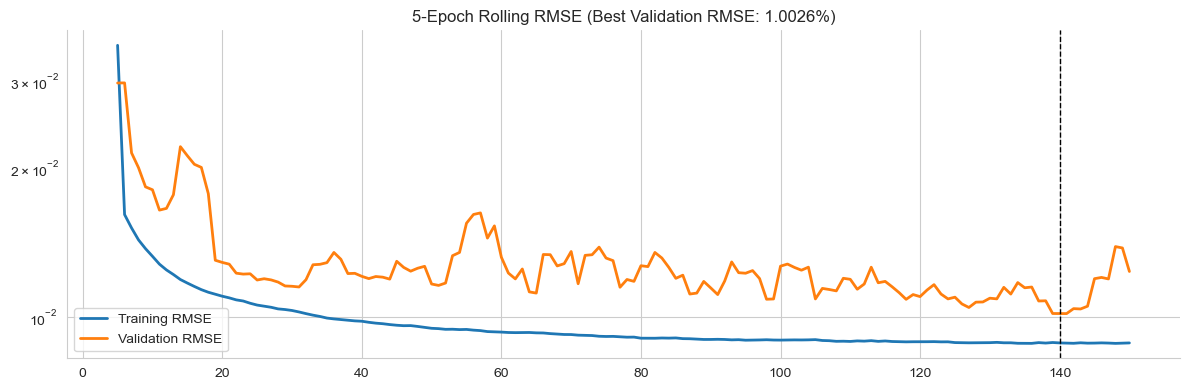

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

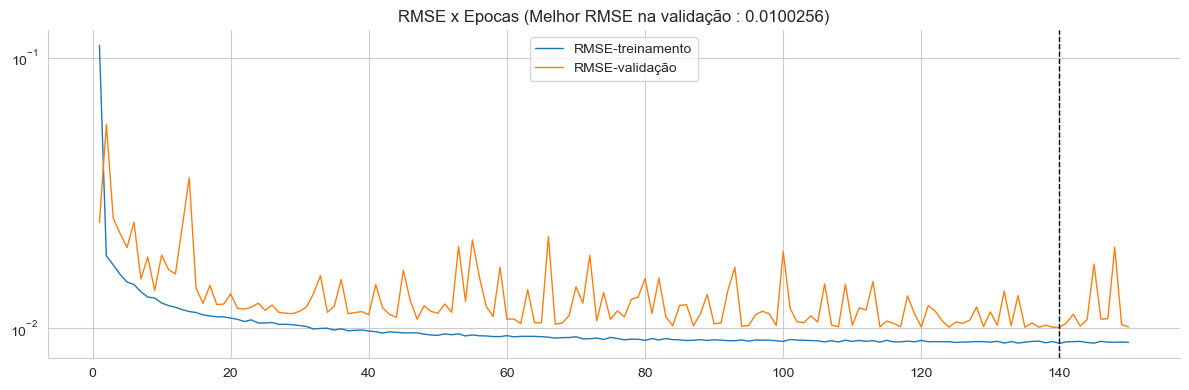

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0086 | Test RMSE: 0.0111
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0083 | Test RMSE: 0.0101


In [22]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [23]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.999198 | Test IC: 0.9817
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.999199 | Test IC: 0.9817


In [24]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-MinMax-Daily-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-MinMax-Daily-Scaled-Test.txt' , test_predict_scaled, delimiter =';')
test_predict_scaled[:,0]

array([0.8286516 , 0.8019667 , 0.78282255, 0.791091  , 0.810436  ,
       0.822331  , 0.8240639 , 0.8369206 , 0.8508635 , 0.8461535 ,
       0.8380429 , 0.8240803 , 0.84073293, 0.8484536 , 0.85423607,
       0.8474331 , 0.8443701 , 0.8543406 , 0.86484766, 0.86462426,
       0.84970015, 0.8482757 , 0.8575497 , 0.84769654, 0.8318043 ,
       0.818253  , 0.81929255, 0.81288785, 0.8292299 , 0.81535685,
       0.8146623 , 0.8206822 , 0.8134677 , 0.8265579 , 0.83023113,
       0.82425404, 0.8078113 , 0.8101397 , 0.7966849 , 0.79517335,
       0.7893248 , 0.7848175 , 0.7764263 , 0.780176  , 0.78721327,
       0.7840795 , 0.8017299 , 0.79152524, 0.7790551 , 0.7742726 ,
       0.7727357 , 0.7708694 , 0.7767828 , 0.76601774, 0.7568642 ,
       0.75690097, 0.75114506, 0.7330172 , 0.7386951 , 0.7461503 ,
       0.75863034, 0.76420504, 0.7792477 , 0.765825  , 0.76140004,
       0.76395386, 0.75738263, 0.7556817 , 0.7636728 , 0.7984958 ,
       0.80626684, 0.80260426, 0.80036515, 0.7979889 , 0.79898

In [25]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

np.savetxt('Data/Output/LSTM-Jansen-MinMax-Daily-Train.txt', train_predict, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-MinMax-Daily-Test.txt' , test_predict, delimiter =';')

test_predict

Date
2023-01-02    109802.304688
2023-01-03    106535.929688
2023-01-04    104192.585938
2023-01-05    105204.687500
2023-01-06    107572.617188
                  ...      
2023-12-21    130534.109375
2023-12-22    131797.203125
2023-12-26    132421.453125
2023-12-27    133183.328125
2023-12-28    133832.656250
Length: 248, dtype: float32

In [26]:
#===============================================================================================================================
# RESULTS - PRICE - PRED - EXPORT
#===============================================================================================================================
dftest_predict=test_predict.to_frame()
dftest_predict


,0
Date,
2023-01-02,109802.304688
2023-01-03,106535.929688
2023-01-04,104192.585938
2023-01-05,105204.687500
2023-01-06,107572.617188
...,...
2023-12-21,130534.109375
2023-12-22,131797.203125
2023-12-26,132421.453125


In [27]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([106376.02, 104165.74, 105334.46, 107641.32, 108963.7 , 109129.57,
       110816.71, 112517.08, 111850.22, 110916.08, 109212.66, 111439.12,
       112228.39, 112921.88, 112040.64, 111737.28, 113028.15, 114270.07,
       114177.55, 112316.16, 112273.01, 113430.54, 112073.55, 110140.64,
       108523.47, 108721.58, 107829.73, 109951.49, 108008.05, 108078.27,
       108836.47, 107848.81, 109600.14, 109941.46, 109176.92, 107152.05,
       107592.87, 105798.43, 105711.05, 104931.93, 104384.67, 103325.61,
       103865.99, 104700.32, 104227.93, 106540.32, 105071.19, 103618.2 ,
       103121.36, 102932.38, 102675.45, 103434.66, 101981.53, 100922.89,
       100998.13, 100220.63,  97926.34,  98829.27,  99670.47, 101185.09,
       101792.52, 103713.45, 101882.2 , 101506.18, 101869.45, 100977.85,
       100821.73, 101846.64, 106213.76, 106889.71, 106457.85, 106279.37,
       106015.67, 106163.23, 103912.94, 104366.82, 103946.58, 103220.09,
       102312.1 , 102923.31, 104431.63, 101926.95, 

In [28]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1024.70 | Test RMSE: 1225.61'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 1010.82 | Test RMSE: 1232.08'

In [29]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp['data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,110169.539062,NaN,110169.539062,Train
2023-01-02,106376.02,NaN,109802.304688,109802.304688,Test
2023-01-03,104165.74,NaN,106535.929688,106535.929688,Test
2023-01-04,105334.46,NaN,104192.585938,104192.585938,Test
2023-01-05,107641.32,NaN,105204.687500,105204.687500,Test
...,...,...,...,...,...
2023-12-21,132182.01,NaN,130534.109375,130534.109375,Test
2023-12-22,132752.93,NaN,131797.203125,131797.203125,Test
2023-12-26,133532.92,NaN,132421.453125,132421.453125,Test


In [30]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-MinMax-Daily.xlsx')

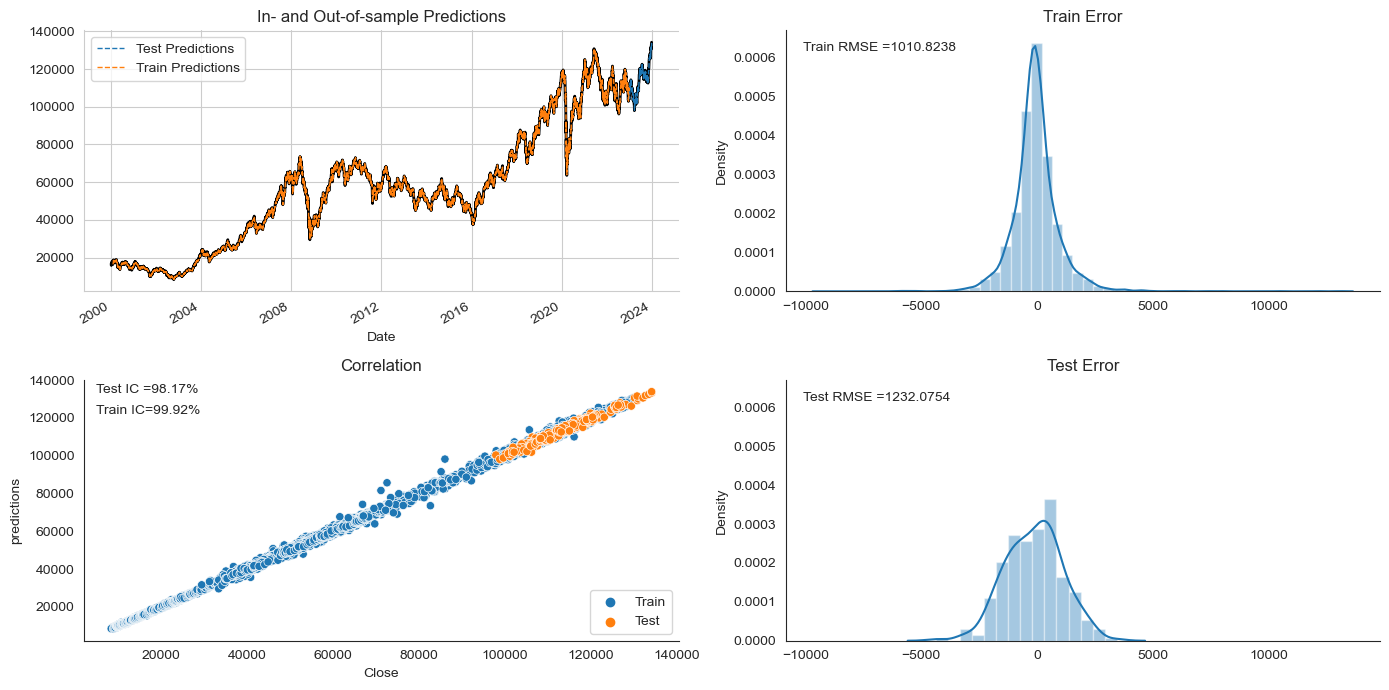

In [31]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
